In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

Using TensorFlow backend.


In [0]:
df = pd.read_csv('/content/drive/My Drive/NITD Internship/nitdata.csv', index_col='Date', parse_dates=True)

In [0]:
df.drop(['Temperature', 'Humidity', 'Carbon Monoxide', 'Nitrogen Dioxide', 'Dust (PM10)'], axis=1, inplace=True)

In [4]:
df.head(4)

,Dust (PM2.5)
Date,
2020-05-22 18:55:07,44
2020-05-22 18:55:01,43
2020-05-22 18:54:57,43
2020-05-22 18:54:51,43


In [0]:
# converting all 0 in df to NaN
df.replace(to_replace=0, value=np.nan, inplace=True)
# filling them with mean
df.fillna(df.mean(), inplace=True)
df.columns = ['dust']

In [0]:
df = df.groupby('Date').mean()

In [0]:
dataset = pd.DataFrame()
dataset['dust'] = df.dust.resample('H').mean()

In [8]:
dataset.head(4)

,dust
Date,
2020-05-16 02:00:00,25.574704
2020-05-16 03:00:00,25.710770
2020-05-16 04:00:00,56.169221
2020-05-16 05:00:00,89.782406


In [9]:
dataset.isnull().sum()

dust    0
dtype: int64

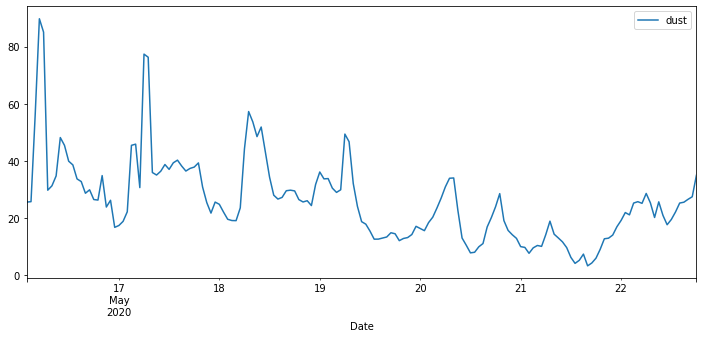

In [10]:
dataset.plot(figsize=(12,5));

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

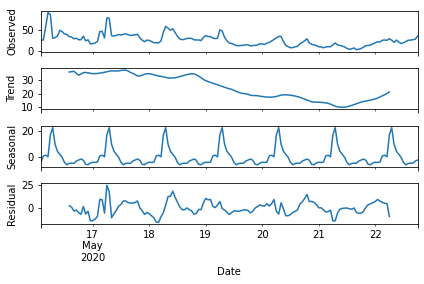

In [12]:
results = seasonal_decompose(dataset['dust'])
results.plot();

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 161 entries, 2020-05-16 02:00:00 to 2020-05-22 18:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dust    161 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	total = pd.concat(cols, axis=1)
	total.columns = names
	if dropnan:
		total.dropna(inplace=True)
	return total

In [0]:
def prepare_data(series, n_test, n_lag, n_seq):
	raw_values = series.values
	# rescale values to 0, 1
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaled_values = scaler.fit_transform(raw_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	supervised = series_to_supervised(scaled_values)
	supervised_values = supervised.values
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [0]:
n_lag = 1
n_seq = 1
n_test = 24

In [0]:
scaler, train, test = prepare_data(dataset, n_test, n_lag, n_seq)

In [20]:
train.shape

(136, 2)

In [0]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [0]:
n_epochs = 1500
n_batch = 1
n_neurons = 1

In [0]:
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1)                    12        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [0]:
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	forecast = model.predict(X, batch_size=n_batch)
	return [x for x in forecast[0, :]]

In [0]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		forecast = forecast_lstm(model, X, n_batch)
		forecasts.append(forecast)
	return forecasts

In [0]:
forecast_test = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

In [0]:
# inverse data transform on forecasts
def inverse_transform(forecasts, scaler):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		inverted.append(inv_scale)
	return array(inverted)

In [0]:
forecast_test = inverse_transform(forecast_test, scaler)

In [0]:
actual = [row[n_lag:] for row in test]
actual = inverse_transform(actual, scaler)

In [0]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('RMSE: %f' % (rmse))

RMSE of forecasted data and test set

In [48]:
evaluate_forecasts(actual, forecast_test, n_lag, n_seq)

RMSE: 3.257588


In [0]:
def predict(model, n_batch, test, num, n_lag, n_seq):
	forecasts = list()
	prev_X = test[-1, n_lag:]
	for i in range(num):
		X = prev_X
		forecast = forecast_lstm(model, X, n_batch)
		forecasts.append(forecast)
		prev_X = array(forecast)
	return forecasts

No.of forecast you want to make after the test set -> **num**

In [0]:
num = 24

In [0]:
n_predictions = predict(model, n_batch, test, num, n_lag, n_seq)

In [0]:
n_predictions = inverse_transform(n_predictions, scaler)

In [56]:
n_predictions

array([[36.564922],
       [34.468136],
       [34.165398],
       [33.900215],
       [33.700912],
       [33.54972 ],
       [33.434692],
       [33.346973],
       [33.279953],
       [33.228664],
       [33.189373],
       [33.159256],
       [33.136143],
       [33.11841 ],
       [33.104782],
       [33.09432 ],
       [33.086273],
       [33.08009 ],
       [33.075336],
       [33.07169 ],
       [33.068882],
       [33.066723],
       [33.065056],
       [33.063786]], dtype=float32)